In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

sns.set_style(style='whitegrid', rc={'family':'sans-serif', 'sans-serif':['Helvetica'], 'weight':'light', 'size':9})
sns.set_context("paper", font_scale=0.8, rc={"font.size":10, "axes.labelsize":6})
#rc('font', **{'family':'sans-serif', 'sans-serif':['Helvetica'], 'weight':'light', 'size':9})
plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [44]:
colors = {
    'd_orange':r'#d8912d',
    'l_orange':r'#eca740',
    'yellow':r'#f4ca45',
    'green':r'#81aa6b',
    'black':r'#1e212b'
    }

In [45]:
def cm2inch(value):
    return value/2.54

def new_figure(height=5, type='body'):
    if type == 'body':
        width = 10.75
    elif type == 'margin':
        width = 5
    elif type == 'wide':
        width = 16.5
    else:
        width = 10.75
    fig = plt.figure(figsize=(cm2inch(width), cm2inch(height)))
    fig.set_tight_layout(True)
    return fig

def tuftefy(ax):
    """Remove spines and tick position markers to reduce ink."""
    # 
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    #ax.spines["bottom"].set_color('grey')
    #ax.grid(color="w", alpha=0.5)
    ax.get_yaxis().grid(False)
    ax.get_xaxis().grid(False)
    ax.tick_params(axis='both', which='major', pad=0)
    
def save_figure(figure, name):
    figure.savefig('../images/{}'.format(name), dpi=300)

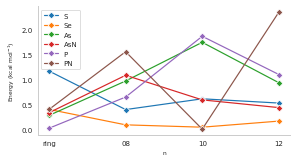

In [46]:
energies = {
    'S':None,
    'Se':None,
    'As':None,
    'AsN':None,
    'P':None,
    'PN':None
}

for key in energies.keys():
    energies[key] = np.abs(np.random.standard_normal(4))

x = [1, 2, 3, 4]

f = new_figure(height=6, type='body')

for family in energies.keys():
    ax = sns.lineplot(x=x, y=energies[family], label=family, marker='D')

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['ring', '08', '10', '12'])
ax.set_xlabel('n')
ax.set_ylabel(r'Energy (kcal mol$^{-1}$)')
tuftefy(ax)

save_figure(f, 'sunflower-stability.pdf')

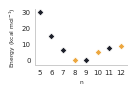

In [51]:
n0 = [5, 6, 7, 9, 11]
energies0 = [30, 15, 6, 0, 7.5]

n1 = [8, 10, 12]
energies1 = [0, 4.8, 8.5]

f = new_figure(height=3.5, type='margin')

ax = sns.scatterplot(x=n0, y=energies0, color=colors['black'], marker='D')
ax = sns.scatterplot(x=n1, y=energies1, color=colors['l_orange'], marker='D')

ax.set_yticks([0, 10, 20, 30])
ax.set_xticks(range(5, 13))
ax.set_xlabel('n')
ax.set_ylabel(r'Energy (kcal mol$^{-1}$)')
tuftefy(ax)

save_figure(f, 'sulflower-strain.pdf')

In [52]:
import moleculetools as mt

ModuleNotFoundError: No module named 'moleculetools'

In [34]:
bond_path = "/Users/oscar/Dropbox/s3/flowers/bond-lengths/"

def get_bond_df(mol_id):
    els, coords = mt.read_xyz(bond_path + mol_id + '.xyz')
    structure = mt.Structure(els, coords)
    structure.find_bonds()
    bond_types = {}
    for bond in structure.bonds:
        bond_types.setdefault(bond['elements'], []).append(bond)
    return pd.DataFrame(structure.bonds)

bonds08 = get_bond_df('as08')
bonds10 = get_bond_df('as10')

bins = np.linspace(1.35, 1.95, 10)
alpha = 0.7

f = new_figure(height=5, type='margin')
ax = sns.distplot(a=bonds08['distance'], bins=bins, color=colors['black'], kde=False, rug=True, hist=True, hist_kws=dict(alpha=alpha))
ax = sns.distplot(a=bonds10['distance'], bins=bins, color=colors['d_orange'], kde=False, rug=True, hist=True, hist_kws=dict(alpha=alpha))
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'C')], bins=5, color=colors['black'], kde=True, rug=True, hist=False)
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'As')], bins=5, color=colors['l_orange'], kde=True, rug=True, hist=False)
tuftefy(ax)

save_figure(f, 'hist-test.pdf')

NameError: name 'mt' is not defined

In [35]:
def distplot_with_hue(data=None, x=None, hue=None, row=None, col=None, legend=True, **kwargs):
    _, bins = np.histogram(data[x].dropna())
    g = sns.FacetGrid(data, hue=hue, row=row, col=col)
    g.map(sns.distplot, x, **kwargs)
    if legend and (hue is not None) and (hue not in [x, row, col]):
        g.add_legend(title=hue) 

In [36]:
f = new_figure(height=5, type='margin')
ax = distplot_with_hue(data=bonds08, x='distance', hue='elements', bins=bins)
ax = distplot_with_hue(data=bonds10, x='distance', hue='elements', bins=bins)
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'C')], bins=5, color=colors['black'], kde=True, rug=True, hist=False)
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'As')], bins=5, color=colors['l_orange'], kde=True, rug=True, hist=False)
#tuftefy(ax)

NameError: name 'bonds08' is not defined

<Figure size 141.732x141.732 with 0 Axes>

In [37]:
bonds08

NameError: name 'bonds08' is not defined

In [31]:
bonds08['label'] = np.random.randint(0, 2, 32)
bonds08

NameError: name 'bonds08' is not defined

In [80]:
bonds08.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
atoms       32 non-null object
elements    32 non-null object
distance    32 non-null float64
label       32 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ KB


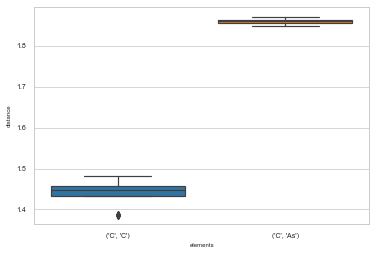

In [88]:
sns.boxplot(data=bonds08, x='elements', y='distance')